In [2]:
from plants.faults import strikeslip
import os
import Solve_IVP_NS  # Ensure that this module is in your PYTHONPATH
import numpy as np
import matplotlib.pyplot as plt
import time



In [3]:
import autograd.numpy as np
from scipy.optimize import root
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm
import time 

import torch as th
from torch import nn
from stable_baselines3.td3.policies import TD3Policy
from stable_baselines3.sac.policies import SACPolicy  
from stable_baselines3.common.vec_env import VecNormalize
import gymnasium as gym
from gymnasium import spaces

from sb3_contrib import TQC
from stable_baselines3 import TD3, DDPG, SAC
from stable_baselines3.common.env_util import make_vec_env, DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

from Solve_IVP_NS.rl.env import AdaptiveStepperEnv
from Solve_IVP_NS.rl.callbacks import RewardCallback, CustomMetricsCallback

sizes = 30
plt.rcParams.update({
    'font.size': sizes,
    'axes.titlesize': sizes,
    'axes.labelsize': sizes,
    'xtick.labelsize': sizes,
    'ytick.labelsize': sizes,
    'legend.fontsize': sizes,
    'figure.titlesize': sizes,
    'text.usetex': True,
    'font.family': 'Times',
    # Embed fonts in vector outputs so text is editable
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    # Keep LaTeX preamble minimal to prevent bloat and ensure Times math
    'text.latex.preamble': r'\usepackage{amsmath}\usepackage{mathptmx}',
    # Cleaner default look; we'll style axes explicitly in plotting code
    'axes.grid': False,
})


import Solve_IVP_NS  # Ensure that this module is in your PYTHONPATH
th.set_default_dtype(th.float32)

In [4]:
from pathlib import Path
DATA_DIR = str((Path.cwd() / "Data").resolve())
print(f"Loading: {DATA_DIR}/kijs_2x2elem-3x3length.npy")

# Initialize fault model
fault = strikeslip.qs_strikeslip_fault(
    zdepth=3, xlength=3, Nz=1, Nx=1, 
    G=30000., rho=2.5e-3, zeta=0.8/3, 
    Ks_path="./Data/", gamma_s=25., gamma_w=10., 
    sigma_ref=100., depth_ini=0., vinf=3.171e-10, 
    Dmu_estimate=.5,
)

# Get plant parameters
MA, KS, ES, SIGMA_N, VINF_raw = fault.get_plant()

# Print diagnostic information
print(f"Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz: {KS.sum()}")
print(f"Approximate value of total stiffness assuming a patch of length Lx: {3.333333333333333e-07}")
print(f"Calculated value: {3.962559156372552e-07}")
print(f"Units are in: mm,N,ms,MPa,gr")

Loading: /home/david/Desktop/Solve_ivp_ns-main/RL_Adaption/2D_FAULT/Data/kijs_2x2elem-3x3length.npy
Loading: ./Data/kijs_1x1elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  2.680356930289319e-07
Units are in: mm,N,ms,MPa,gr
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz: 1.0000000000000002
Approximate value of total stiffness assuming a patch of length Lx: 3.333333333333333e-07
Calculated value: 3.962559156372552e-07
Units are in: mm,N,ms,MPa,gr


In [5]:
N_DOFS = fault.N                                # int
VINF = VINF_raw * np.ones(N_DOFS)               # scalar vinf

# Block matrix for the SSN solver
I_N = np.eye(N_DOFS)
Z_N = np.zeros((N_DOFS, N_DOFS))
A = np.block([
    [MA, Z_N, Z_N],
    [Z_N, I_N, Z_N],
    [Z_N, Z_N, I_N]
])

# Component slice layout
component_slices = [
    slice(0, N_DOFS),
    slice(N_DOFS, 2 * N_DOFS),
    slice(2 * N_DOFS, 3 * N_DOFS)
]

In [6]:
def rhs(t, y):
    n = N_DOFS
    v = y[0:n]
    u = y[n:2 * n]
    s = y[2 * n:3 * n]

    vdot = -(KS @ u) - (ES @ (v - VINF))
    udot = v - VINF
    sdot = np.abs(v)
    return np.concatenate((vdot, udot, sdot))


In [7]:
DMU = -0.1   # Friction drop amount (adjust based on your problem)
DC = 100.0 / fault.Dscale    # Characteristic slip distance (adjust based on your problem)
MU_RES = 0.5
out = np.zeros(3 * N_DOFS, dtype=float)

def con_force(state, fk=None):
    n = N_DOFS
    slip = state[2 * n : 3 * n]

    mu_vals = MU_RES * (1 - DMU/MU_RES * np.exp(-slip / DC)) 
    # mu_vals = np.clip(mu_vals, 0.0, None)

    out = np.zeros_like(state, dtype=float)
    out[:n] = mu_vals * SIGMA_N
    # print("Friction Coefficients:", mu_vals)
    return out


In [8]:
# projection and solver options
projection_opts = {
    'con_force_func': con_force,
    'rhok': 1.0,
    'component_slices': component_slices,
    'constraint_indices': list(range(N_DOFS)),
}

# Tuned nonlinear-solver options shared by VI and SSN
solver_opts_common = dict(
    tol=1e-6,
    max_iter=100,
 )

# Adaptive controller tuned for nonsmooth dynamics
adaptive_opts = dict(
    h0=5e-3,
    h_min=1e-7,
    h_down=0.6,
    h_up=1.8,
    method_order=1,           # conservative order for nonsmooth dynamics
    use_PI=False,              # smoother steps with PI control
    skip_error_indices=[]
 )

# SSN-specific tweaks for robustness and speed
solver_opts_ssn = dict(solver_opts_common)


# VI solver uses the same baseline tolerances but no EW relaxation
solver_opts_vi = dict(solver_opts_common)
solver_opts_vi.update(dict(
    linear_tol_strategy=None
))

In [9]:
y0 = np.zeros(3 * N_DOFS)
friction_force = con_force(y0)
uc = -np.linalg.solve(KS,friction_force[:N_DOFS]) #displacement at frictional instability

u0 = uc * (1 + 1e-5) # peturb uc displacement slighty

y0[ N_DOFS : 2 * N_DOFS] = u0
Uint =  0.5 * np.dot(u0, KS @ u0) #initial internal energy
Uintc =  0.5 * np.dot(uc, KS @ uc) # internal energy at frictional instability used to normalize energy


# print(f"Initial slip values (s0): {u0}")
# print(f"Initial state (y0): {y0}")

In [10]:
import numpy as np

# ---------- small helpers ----------
def _as_vec(x, n):
    if np.isscalar(x):
        return np.full(n, float(x))
    x = np.asarray(x, dtype=float)
    if x.shape != (n,):
        raise ValueError(f"Expected vector of length {n}, got {x.shape}")
    return x

def _sym(A):  # numerical symmetrization
    return 0.5 * (A + A.T)

def _lam_min_spd(M):
    w = np.linalg.eigvalsh(_sym(M))
    if w[0] <= 0:
        raise ValueError("Mass matrix M must be SPD.")
    return float(w[0])

def _first_omega(K, M=None, tol=1e-12):
    K = _sym(K)
    if M is None:
        w = np.linalg.eigvalsh(K)
    else:
        # generalized symmetric eigenproblem via Cholesky of M
        L = np.linalg.cholesky(_sym(M))
        Linv = np.linalg.solve(L, np.eye(L.shape[0]))
        A = Linv.T @ K @ Linv
        w = np.linalg.eigvalsh(_sym(A))
    pos = w[w > tol]
    if pos.size == 0:
        raise ValueError("No positive eigenvalues found for stiffness block.")
    return float(np.sqrt(pos[0]))

# ---------- main estimators ----------
def estimate_v_max_range(
    y0, KS, ES, SIGMA_N, MU_RES, DMU, DC, VINF, M=None,
    patch_indices=None, alpha_values=(1.0, 1.0, 2.0, 2.0)
):
    """
    Returns several max-velocity estimates without time integration.
    Works with vector SIGMA_N and optional mass matrix M.
    """
    SIGMA_N = np.atleast_1d(SIGMA_N).astype(float)
    n = SIGMA_N.size
    v0 = y0[:n]
    u0 = y0[n:2*n]
    s0 = y0[2*n:3*n] if y0.size >= 3*n else np.zeros(n)

    VINF_vec = _as_vec(VINF, n)
    M_eff = None if M is None else _sym(M)

    # weakening amount from your law: mu(0)=MU_RES - DMU  =>  Δμ = -DMU (clamped ≥0)
    dmu = max(0.0, -float(DMU))

    # ---------------- 1) Rigorous energy bound ----------------
    w0 = v0 - VINF_vec
    if M_eff is None:
        T0 = 0.5 * (w0 @ w0)
        lam_min_M = 1.0
    else:
        T0 = 0.5 * (w0 @ (M_eff @ w0))
        lam_min_M = _lam_min_spd(M_eff)
    U0 = 0.5 * (u0 @ (KS @ u0))
    E0 = T0 + U0
    w_max = np.sqrt(max(0.0, 2.0 * E0 / lam_min_M))
    v_rigorous = float(np.linalg.norm(VINF_vec) + w_max)

    # ---------------- 2) KB-style estimate (matrix-tailored) ----------------
    alpha2, alpha3, alpha4, alpha5 = alpha_values  # alpha2 unused here by design
    P = np.arange(n, dtype=int) if patch_indices is None else np.asarray(patch_indices, dtype=int)
    KPP = KS[np.ix_(P, P)]
    MPP = None if M_eff is None else M_eff[np.ix_(P, P)]
    omega1 = _first_omega(KPP, M=MPP)

    ones = np.ones(P.size)
    k_bar = float((ones @ (KPP @ ones)) / (ones @ ones))  # uniform-slip equivalent spring
    delta_tau_avg = float(np.mean(dmu * SIGMA_N[P]))

    v_kb = (alpha3 * alpha5 / (alpha4 * np.pi)) * (delta_tau_avg / k_bar) * omega1
    v_kb = float(np.linalg.norm(VINF_vec) + v_kb)

    # ---------------- 3) Damping-based heuristic ----------------
    diag_ES = np.diag(ES).astype(float)
    pos = diag_ES > 0
    if np.any(pos):
        v_damping = float(np.linalg.norm(VINF_vec) + np.max((dmu * SIGMA_N[pos]) / diag_ES[pos]))
    else:
        v_damping = float(np.inf)  # no viscous ceiling

    # ---------------- 4) Energy + weakening work (heuristic retention) ----------------
    # Total weakening work = sum_i Δμ σ_n,i D_c  (independent of s0 for this law)
    total_weaken_work = float(np.sum(dmu * SIGMA_N * DC))
    E_total = E0 + total_weaken_work

    # crude retention using average modal damping
    k_mean_diag = np.mean(np.diag(KS)[np.diag(KS) > 0]) if np.any(np.diag(KS) > 0) else 0.0
    c_mean_diag = np.mean(diag_ES[pos]) if np.any(pos) else 0.0
    if k_mean_diag > 0 and c_mean_diag > 0:
        omega_n = np.sqrt(k_mean_diag) if M_eff is None else np.sqrt(k_mean_diag / (np.trace(M_eff)/n))
        zeta = c_mean_diag / (2.0 * omega_n)  # M=I scaling
        retention = (0.5 / zeta) if zeta >= 1 else np.exp(-np.pi * zeta / np.sqrt(max(1e-12, 1 - zeta**2)))
    else:
        retention = 1.0
    E_eff = max(0.0, E_total * retention)
    w_max_eff = np.sqrt(2.0 * E_eff / lam_min_M)
    v_energy_fric = float(np.linalg.norm(VINF_vec) + w_max_eff)

    # ---------------- 5) Heterogeneity (local viscous cap) ----------------
    idx = int(np.argmax(dmu * SIGMA_N))
    c_local = ES[idx, idx]
    if c_local > 0:
        v_hetero = float(np.linalg.norm(VINF_vec) + (dmu * SIGMA_N[idx]) / c_local)
    else:
        v_hetero = float(np.inf)

    # pick a “best guess” (finite & smallest), ensure range ordered
    finite = [x for x in [v_kb, v_damping, v_energy_fric, v_hetero] if np.isfinite(x)]
    v_best = min(finite) if finite else v_rigorous
    v_low, v_high = min(0.8 * v_best, v_rigorous), max(v_best, v_rigorous)

    return {
        "rigorous_upper_bound": v_rigorous,
        "kb_estimate": v_kb if np.isfinite(v_kb) else None,
        "damping_estimate": v_damping,
        "energy_with_friction": v_energy_fric,
        "heterogeneous_estimate": v_hetero if np.isfinite(v_hetero) else None,
        "best_estimate": v_best,
        "range": (v_low, v_high),
        "stress_drop_max": float(np.max(dmu * SIGMA_N)),
        "stress_drop_mean": float(np.mean(dmu * SIGMA_N)),
        "kbar": k_bar,
        "omega1": omega1,
        "patch_size": int(P.size),
    }

def print_velocity_estimates(results, label="Velocity Estimates"):
    print(f"\n{label}")
    print("-" * 50)
    print(f"Rigorous Upper Bound:     {results['rigorous_upper_bound']:.6e}")
    if results['kb_estimate'] is not None:
        print(f"KB-style Estimate:        {results['kb_estimate']:.6e}")
    print(f"Damping-based Estimate:   {results['damping_estimate']:.6e}")
    print(f"Energy + Friction Bound:  {results['energy_with_friction']:.6e}")
    if results['heterogeneous_estimate'] is not None:
        print(f"Heterogeneous Estimate:   {results['heterogeneous_estimate']:.6e}")
    print(f"Best Estimate:            {results['best_estimate']:.6e}")
    lo, hi = results['range']
    print(f"Practical Range:          [{lo:.6e}, {hi:.6e}]")
    print(f"Patch size:               {results['patch_size']}")
    print(f"k̄ (uniform-slip):        {results['kbar']:.6e}")
    print(f"ω₁ (rad/your time unit): {results['omega1']:.6e}")
    print(f"Max/Mean Δτ:              {results['stress_drop_max']:.6e} / {results['stress_drop_mean']:.6e}")
# Compute estimates
results = estimate_v_max_range(y0, KS, ES, SIGMA_N, MU_RES, DMU, DC, VINF)
print_velocity_estimates(results, "Fault Model Velocity Estimates")


Fault Model Velocity Estimates
--------------------------------------------------
Rigorous Upper Bound:     1.350014e+04
KB-style Estimate:        7.161972e+02
Damping-based Estimate:   4.218750e+03
Energy + Friction Bound:  8.848767e+03
Heterogeneous Estimate:   4.218750e+03
Best Estimate:            7.161972e+02
Practical Range:          [5.729578e+02, 1.350014e+04]
Patch size:               1
k̄ (uniform-slip):        1.000000e+00
ω₁ (rad/your time unit): 1.000000e+00
Max/Mean Δτ:              2.250000e+03 / 2.250000e+03


In [11]:
# === Full semismooth Newton solves: pure Python vs Numba, plus BDF reference ===
# We run the full integrator twice, once forcing pure Python (use_numba=False)
# and once forcing Numba acceleration (use_numba=True). Then we also solve
# the regularized smooth problem with SciPy's BDF for comparison.
tmax=  30 * fault.second / fault.Tscale

t_span = (0.0, tmax)
# # Make a copy of base solver opts for semismooth Newton
# solver_opts_ssn = solver_opts.copy()
# solver_opts_ssn['max_iter'] = 100


projection_opts_nb = dict(projection_opts)
projection_opts_nb['use_numba'] = True   # force Numba path



# --- Semismooth Newton (Numba) ---
start_nb = time.time()
(t_vals_ssn_nb,
 y_vals_ssn_nb,
 h_vals_ssn_nb,
 fk_vals_ssn_nb,
 solver_info_ssn_nb) = Solve_IVP_NS.solve_ivp_ns(
    fun=rhs,
    t_span=t_span,
    y0=y0,
    method='composite',
    projection='coulomb',
    solver='VI',  # 'semismooth_newton'
    projection_opts=projection_opts_nb,
    solver_opts=solver_opts_ssn,
    adaptive=True,
    adaptive_opts=adaptive_opts,
    atol=1e-6,
    rtol=1e-3,
    h0=30/20 * fault.second / fault.Tscale,
    component_slices=component_slices,
    verbose=False,
    A=A
)
rt_nb = time.time() - start_nb
print(f"Semismooth (Numba)  solve complete in {rt_nb:.3f} s")

# Keep backward-compatible variable nams for downstream post-processing.
# We choose the Numba result as the primary (you can swap to *_py if you prefer).
t_vals_ssn = t_vals_ssn_nb
y_vals_ssn = y_vals_ssn_nb
h_vals_ssn = h_vals_ssn_nb
y_fk_vals_placeholder = fk_vals_ssn_nb  # not used directly, keep for clarity
fk_vals_ssn = fk_vals_ssn_nb



coulomb
Semismooth (Numba)  solve complete in 9.525 s


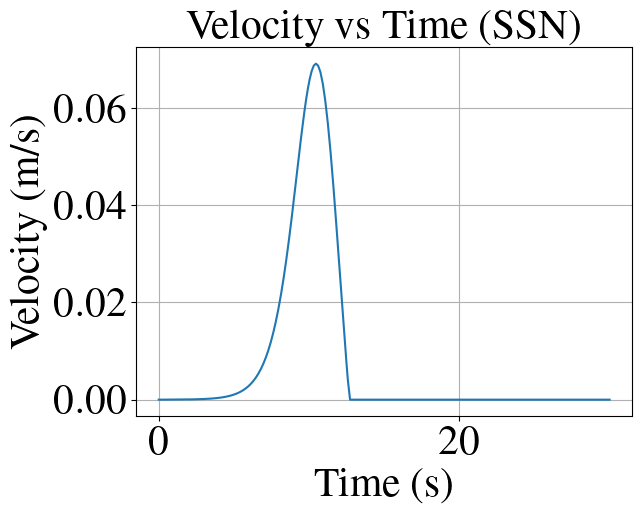

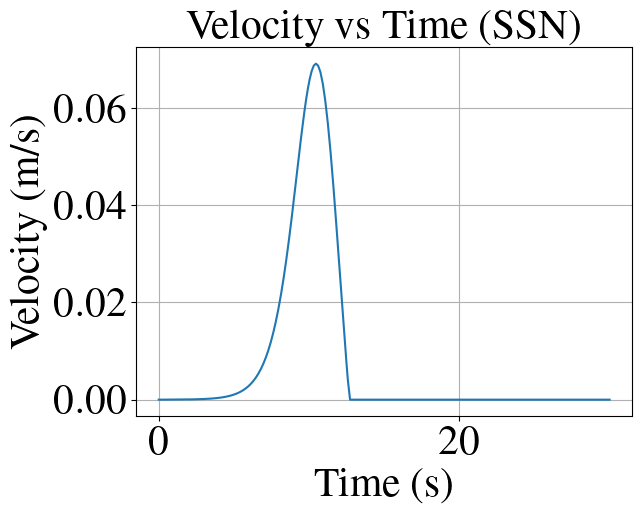

In [13]:
plt.plot(t_vals_ssn * fault.Tscale / fault.second, np.mean(y_vals_ssn[:,:N_DOFS],axis=1) * fault.Vscale, label='Velocity (ssn)')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity vs Time (SSN)')
# plt.legend()
plt.grid()
plt.show()

plt.plot(t_vals_ssn * fault.Tscale / fault.second,y_vals_ssn[:,:N_DOFS] * fault.Vscale, label='Velocity (ssn)')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity vs Time (SSN)')
# plt.legend()
plt.grid()
plt.show()

In [14]:
import numpy as np
alpha_reference = 2.0  # legacy default retained for reference
results = estimate_v_max_range(y0, KS, ES, SIGMA_N, MU_RES, DMU, DC, VINF)
v_max = results['kb_estimate']
print(v_max)


def build_reward_fn(alpha_value: float):
    """Factory returning a reward function parameterized by ``alpha_value``."""
    alpha_value = float(alpha_value)

    def my_reward_fn(solver_perf, dt_attempt, xk, env):
        """
        User-provided reward function parameterized by ``alpha_value``.
        Receives:
          - solver_perf: [runtime, dt, error_LO, error_lil1, error_HI, error,
                          success_LO, success_lil1, success_HI, kiter_LO, iter_lil1, kiter_HI]
          - dt_attempt: the time-step attempted
          - xk: the current state
          - env: the environment instance (for accessing dt_min, dt_max, etc.)
        """
        runtime_inc, dt, error_LO, error_lil1, error_HI, error, \
            success_LO, success_lil1, success_HI, kiter_LO, iter_lil1, kiter_HI = solver_perf
        if dt == 0:
            reward = - (dt_attempt - env.dt_min) / (env.dt_max - env.dt_min)
        else:
            S1 = (dt - env.dt_min) / (env.dt_max - env.dt_min)

            # Track per-step runtime and update the running maximum to normalize S2 dynamically
            if not hasattr(env, 'runtime_history'):
                env.runtime_history = []
            env.runtime_history.append(float(runtime_inc))
            if not hasattr(env, 'max_runtime_seen'):
                env.max_runtime_seen = float(runtime_inc)
            else:
                if runtime_inc > env.max_runtime_seen:
                    env.max_runtime_seen = float(runtime_inc)
            # Compute S2 using the dynamic max; clamp denominator to avoid division by zero
            rt_min = 0.0001
            rt_max = max(rt_min, float(env.max_runtime_seen))
            denom = max(1e-8, rt_max - rt_min)
            S2 = 1 - (float(runtime_inc) - rt_min) / denom
                # # Fallbacks for cold start
            # rt_min = env.rt_min_est if env.rt_min_est is not None else 1e-4
            # rt_max = env.rt_max_est if env.rt_max_est is not None else max(rt_min + 1e-6, float(runtime_inc))

            # # Guard against degenerate spans
            # span = max(1e-8, rt_max - rt_min)

            # # Higher is better (fast step → larger S2), clipped to [0, 1]
            # S2 = (rt_max - float(runtime_inc)) / span
            # print(f'the S2 is:{S2}')

            # S2 = float(np.clip(S2, 0.0, 1.0))

            if S2 < 0:
                print(f'runtime is: {S2}')
            if S1 < 0:
                print(f'S1 is: {S1}')
            A = np.exp(-alpha_value * error)
            if A < 0:
                print(f'A is: {A}')
            reward = S1 * S2 * A
        return reward

    return my_reward_fn


def build_obs_fn(alpha_value: float):
    """
    Factory returning an observation function that uses the SAME alpha as the reward.
    This guarantees consistency: both reward and observation use identical alpha_value.

    Signature of returned function matches environment calls:
      obs_fn(dt_attempt, converged, xk, solver_perf, fk, env)
    """
    alpha_value = float(alpha_value)

    def my_obs_fn(dt_attempt, converged, xk, solver_perf, fk=None, env=None):
        # We require env to compute normalized dt; env will be provided by the caller.
        assert env is not None, "env must be provided by AdaptiveStepperEnv"

        n = N_DOFS
        # Views to avoid copies
        v = xk[:n]
        u = xk[n:2*n]

        # Average velocity (equal-weight)
        avg_v = float(np.mean(v))

        # Internal energy and normalization
        ks_u = KS @ u
        E_int = 0.5 * float(np.dot(u, ks_u))
        try:
            E_norm = float(E_int / Uintc) if Uintc > 0 else 0.0
        except NameError:
            E_norm = float(E_int)

        if dt_attempt is None:
            # Keep the reset branch intact: return defaults but with E_norm and avg_v in the first two slots
            return np.array([
                E_norm,           # normalized internal energy at reset
                avg_v / v_max,    # average velocity at reset
                1.005,            # placeholder to preserve prior behavior
                0.0,              # converged flag default
                0.0,              # exp(-alpha*0) == 1
                0.5,              # normalized dt default
            ], dtype=np.float64)

        # Normal execution branch
        runtime_inc, dt, error_LO, error_lil1, error_HI, error, \
            success_LO, success_lil1, success_H, kiter_LO, iter_lil1, kiter_HI = solver_perf

        # Normalized dt in [0,1]
        dt_norm = (dt_attempt - env.dt_min) / (env.dt_max - env.dt_min) if env.dt_max > env.dt_min else 0.0
        # print(f'Enorm: ')
        # Use the EXACT same alpha as the reward function
        return np.array([
            E_norm,                          # normalized internal energy
            avg_v / v_max,                   # average velocity
            (env.iter_error / 4) if hasattr(env, 'iter_error') else 0.0,
            float(converged),
            float(np.exp(-alpha_value * error)),
            float(dt_norm),
        ], dtype=np.float64)

    return my_obs_fn

716.1972466596955


Preparing training runs with alpha = 0.01
------------------------------------------------------------
Training TQC adaptive controller with alpha = 0.01


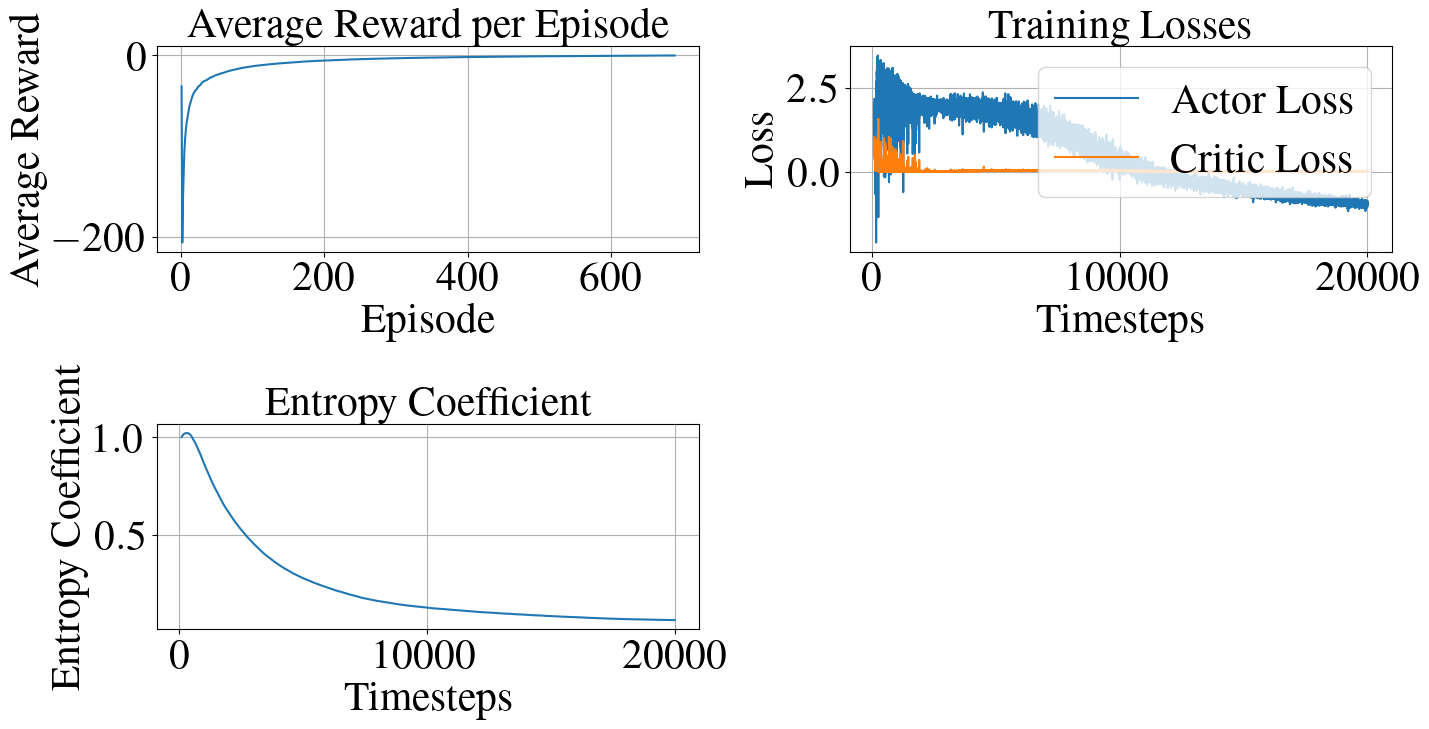

TQC training time: 474.01 seconds
------------------------------------------------------------
Training TD3 adaptive controller with alpha = 0.01
S1 is: -3.353112494514363e-17
S1 is: -3.353112494514363e-17


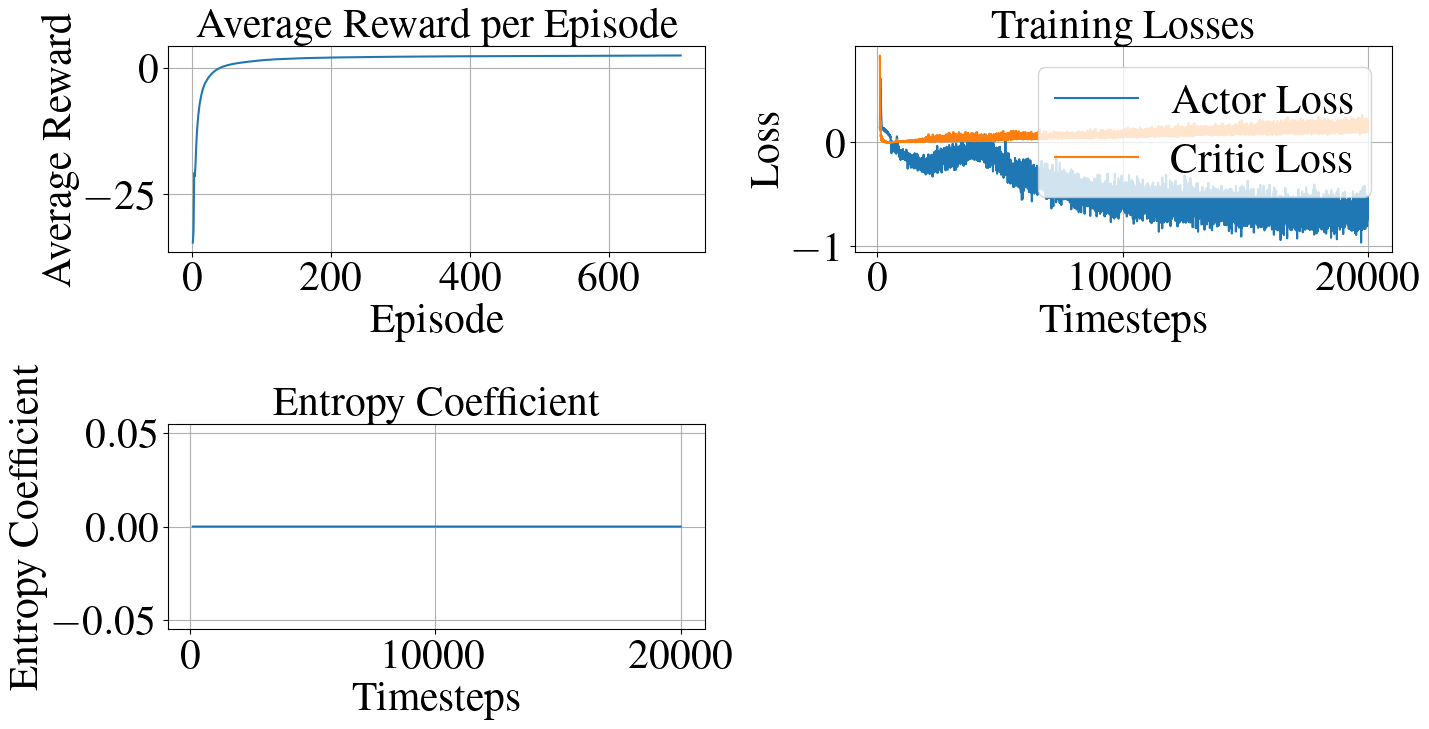

TD3 training time: 402.65 seconds
Preparing training runs with alpha = 0.1
------------------------------------------------------------
Training TQC adaptive controller with alpha = 0.1


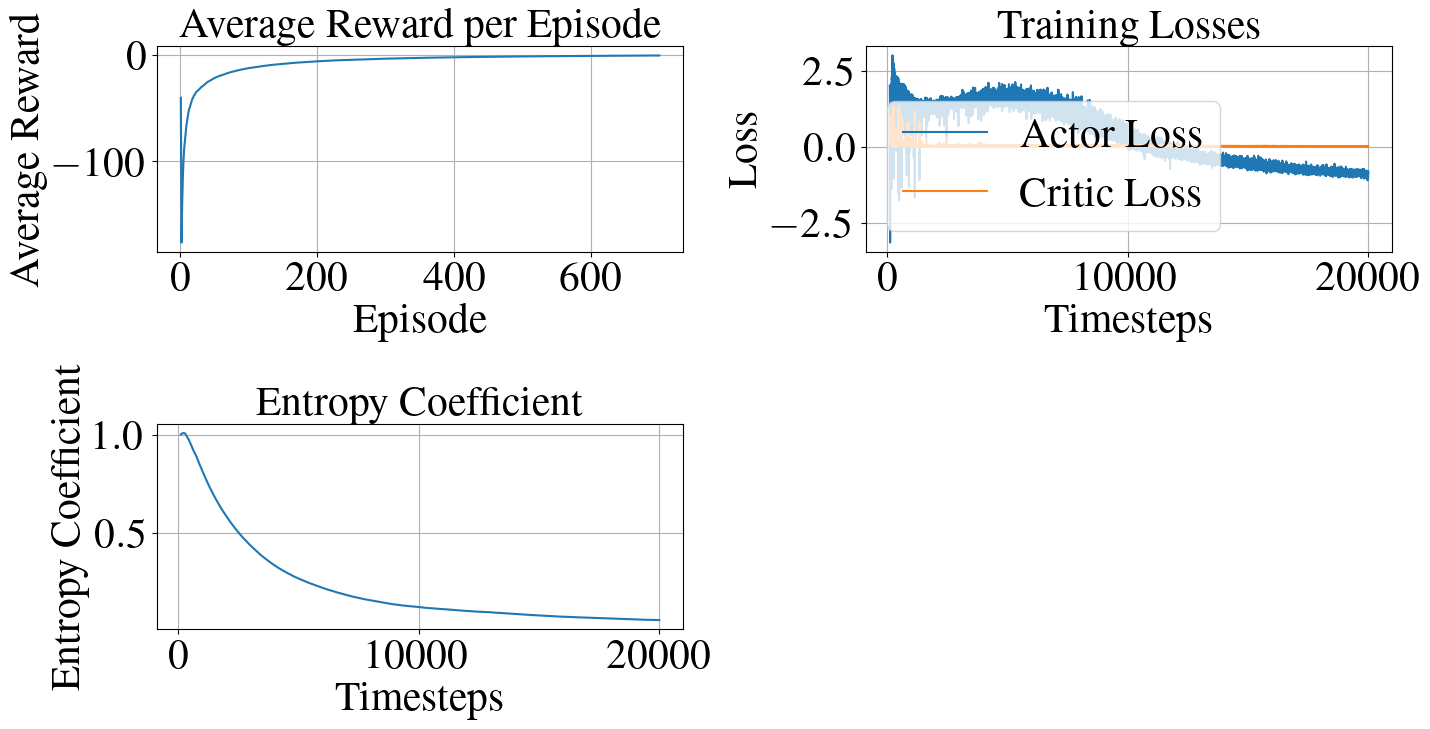

TQC training time: 466.20 seconds
------------------------------------------------------------
Training TD3 adaptive controller with alpha = 0.1


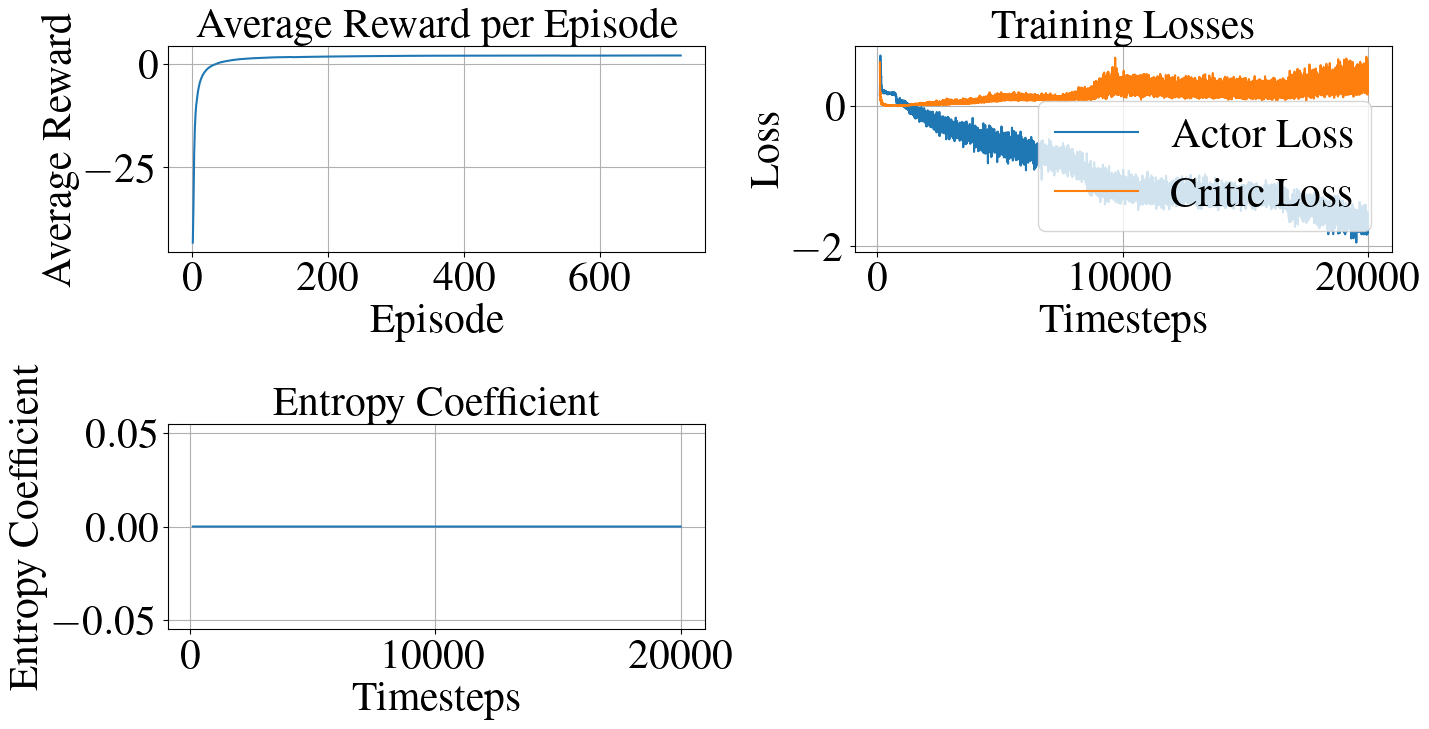

TD3 training time: 347.45 seconds
Preparing training runs with alpha = 1.0
------------------------------------------------------------
Training TQC adaptive controller with alpha = 1.0


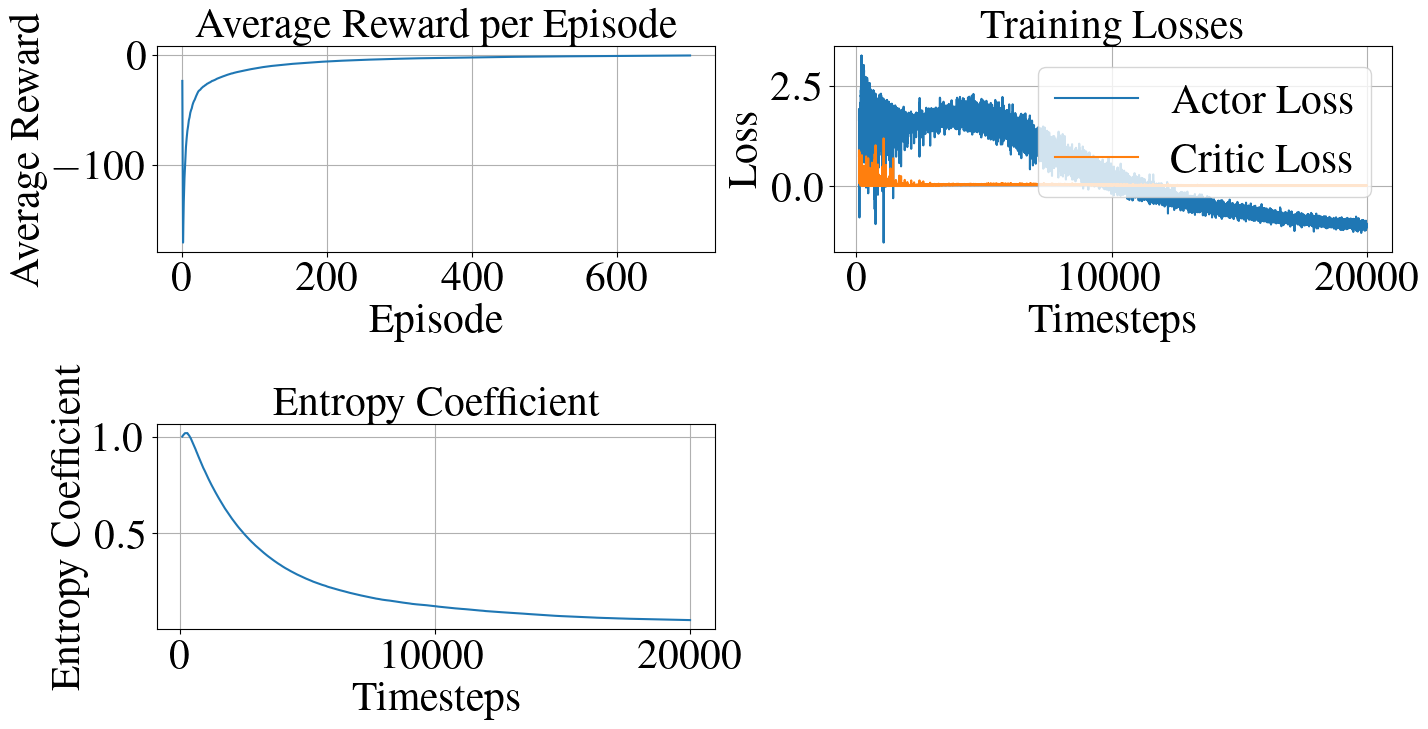

TQC training time: 463.89 seconds
------------------------------------------------------------
Training TD3 adaptive controller with alpha = 1.0


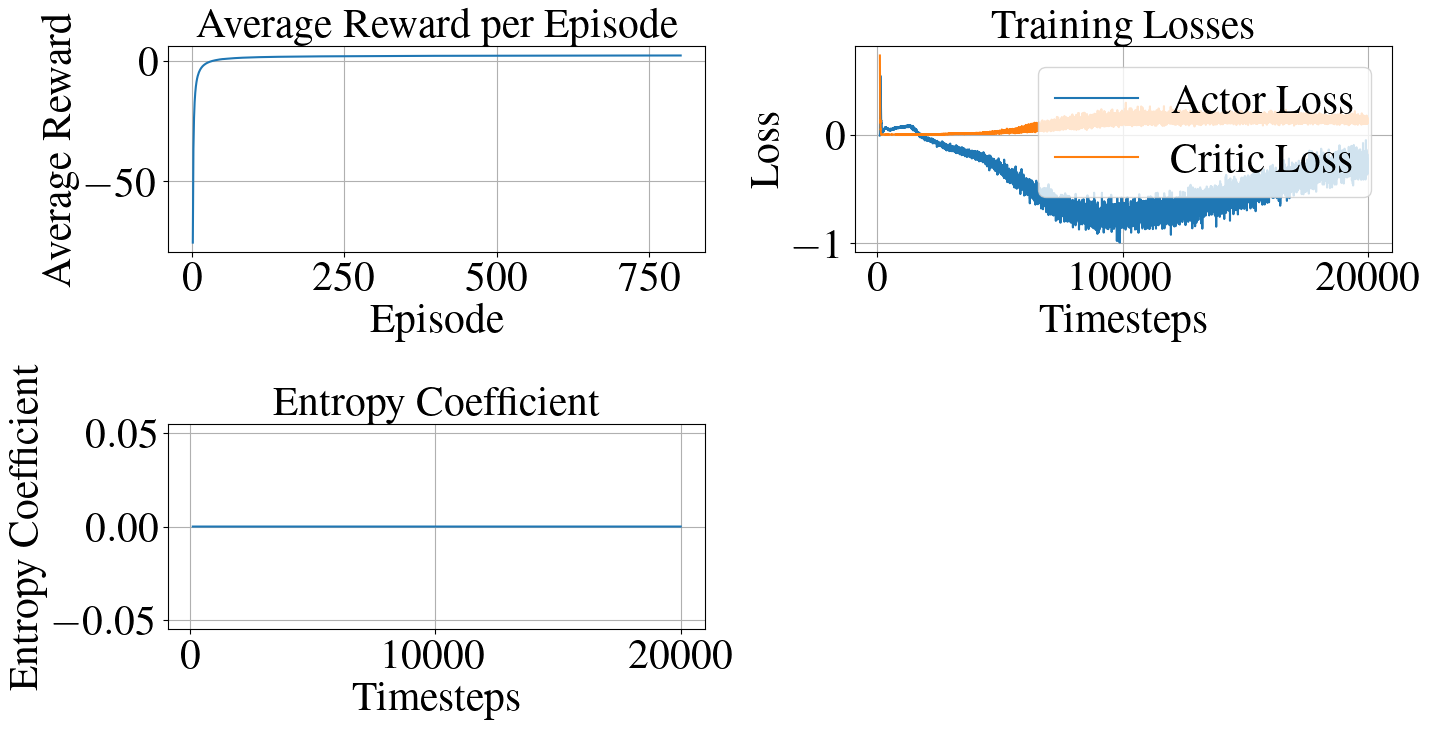

TD3 training time: 358.58 seconds
Preparing training runs with alpha = 2.0
------------------------------------------------------------
Training TQC adaptive controller with alpha = 2.0


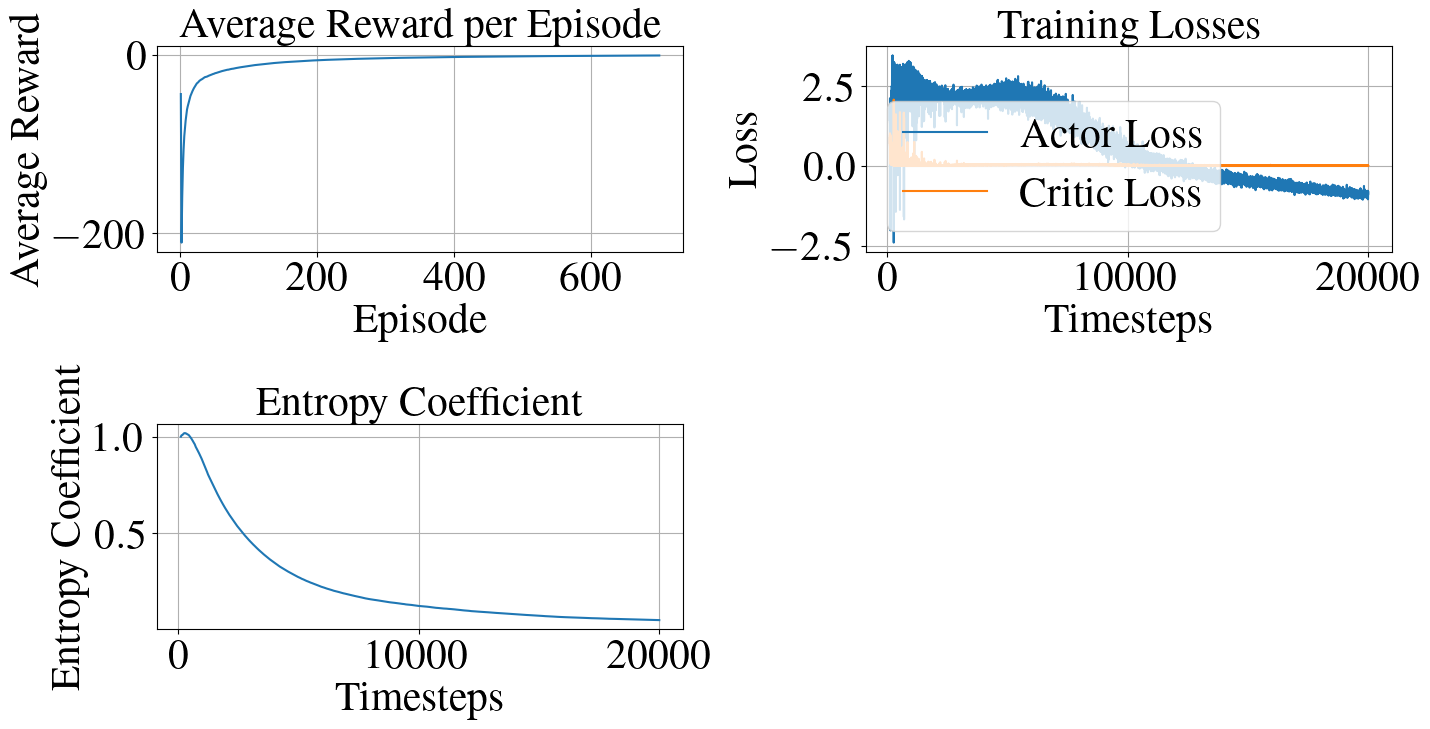

TQC training time: 422.14 seconds
------------------------------------------------------------
Training TD3 adaptive controller with alpha = 2.0


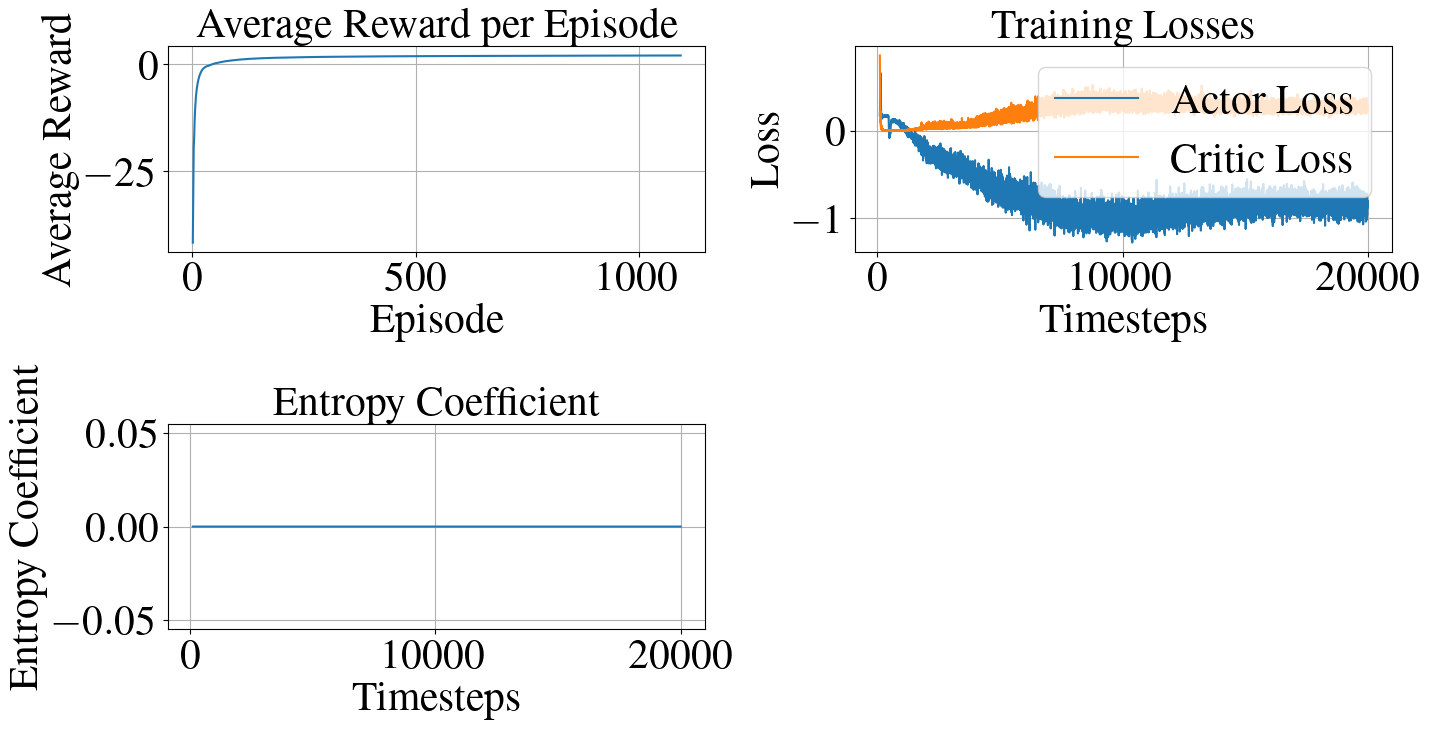

TD3 training time: 445.03 seconds
Preparing training runs with alpha = 10.0
------------------------------------------------------------
Training TQC adaptive controller with alpha = 10.0


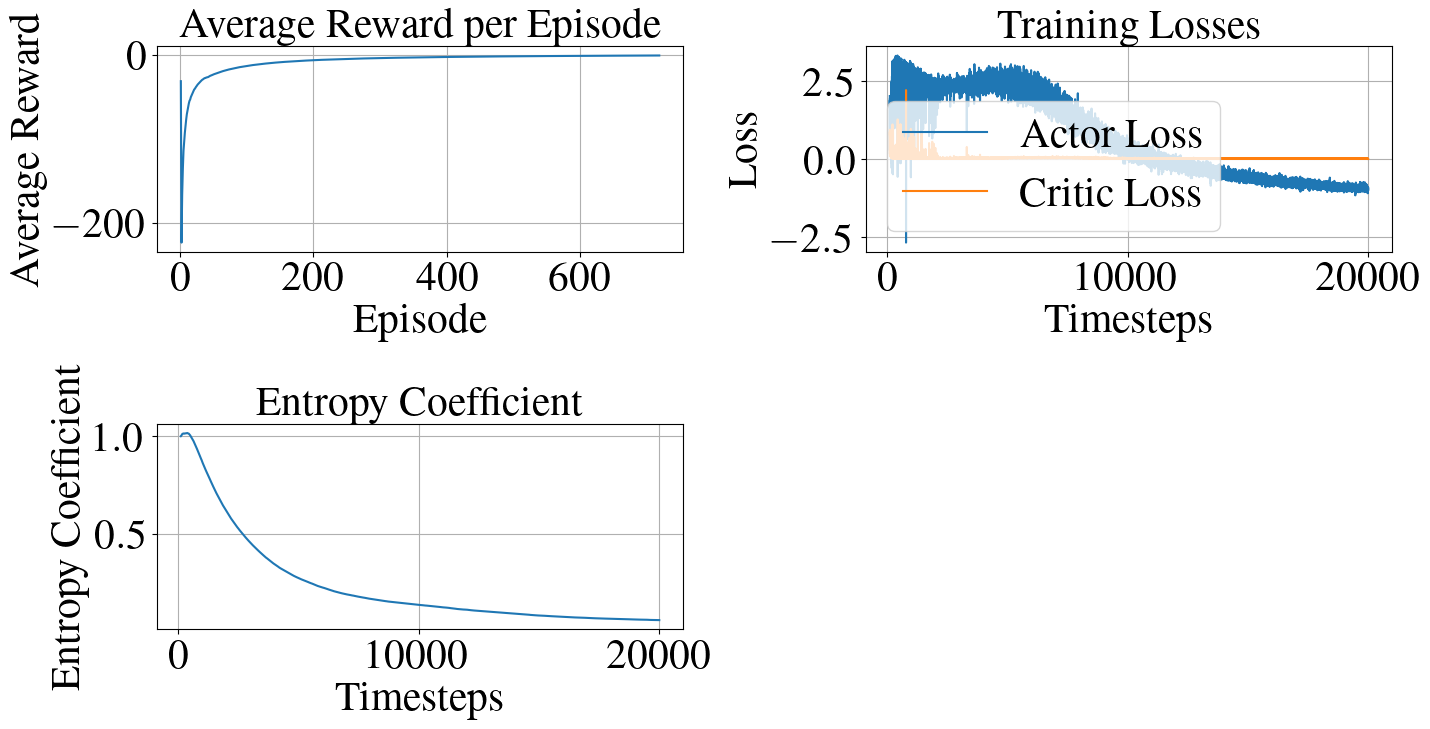

TQC training time: 470.71 seconds
------------------------------------------------------------
Training TD3 adaptive controller with alpha = 10.0
S1 is: -7.512574670308505e-20
S1 is: -7.512574670308505e-20


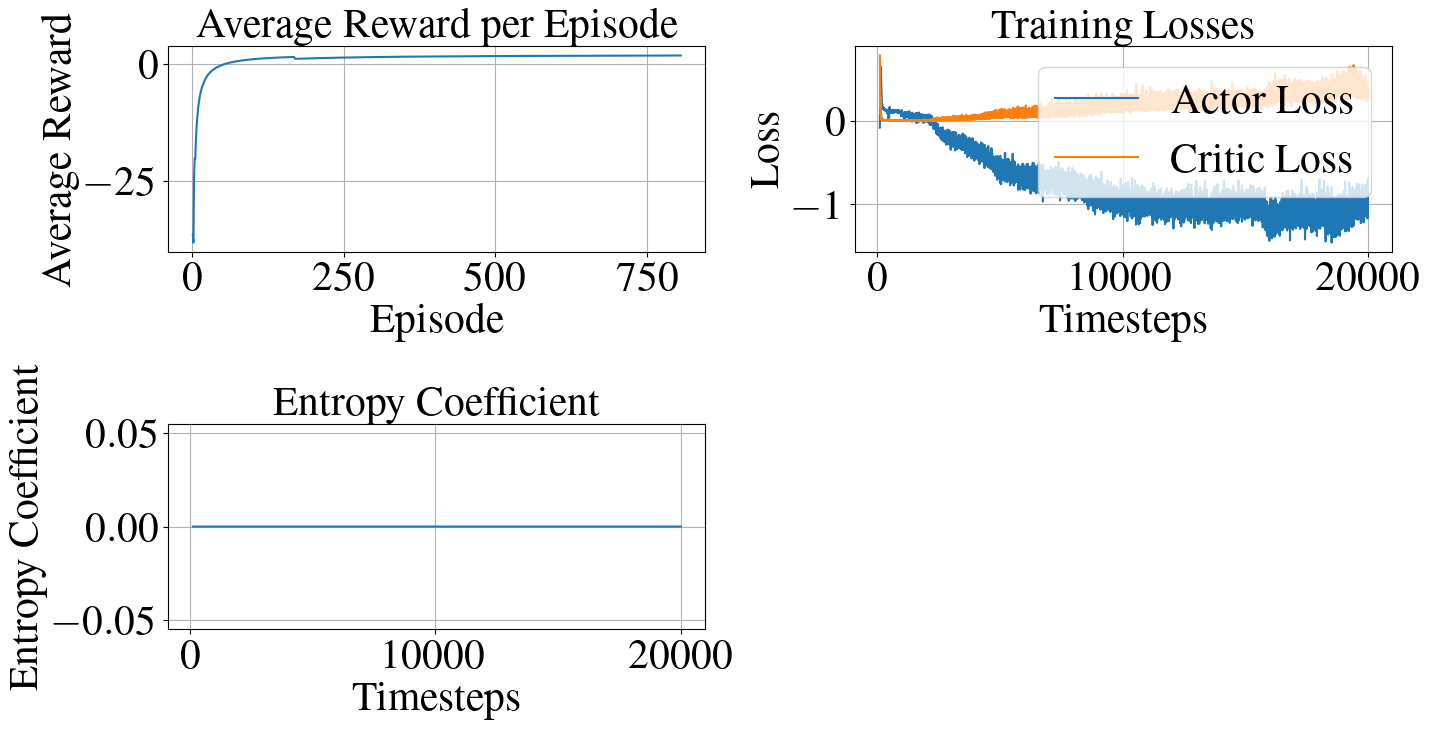

TD3 training time: 412.05 seconds
Preparing training runs with alpha = 100.0
------------------------------------------------------------
Training TQC adaptive controller with alpha = 100.0


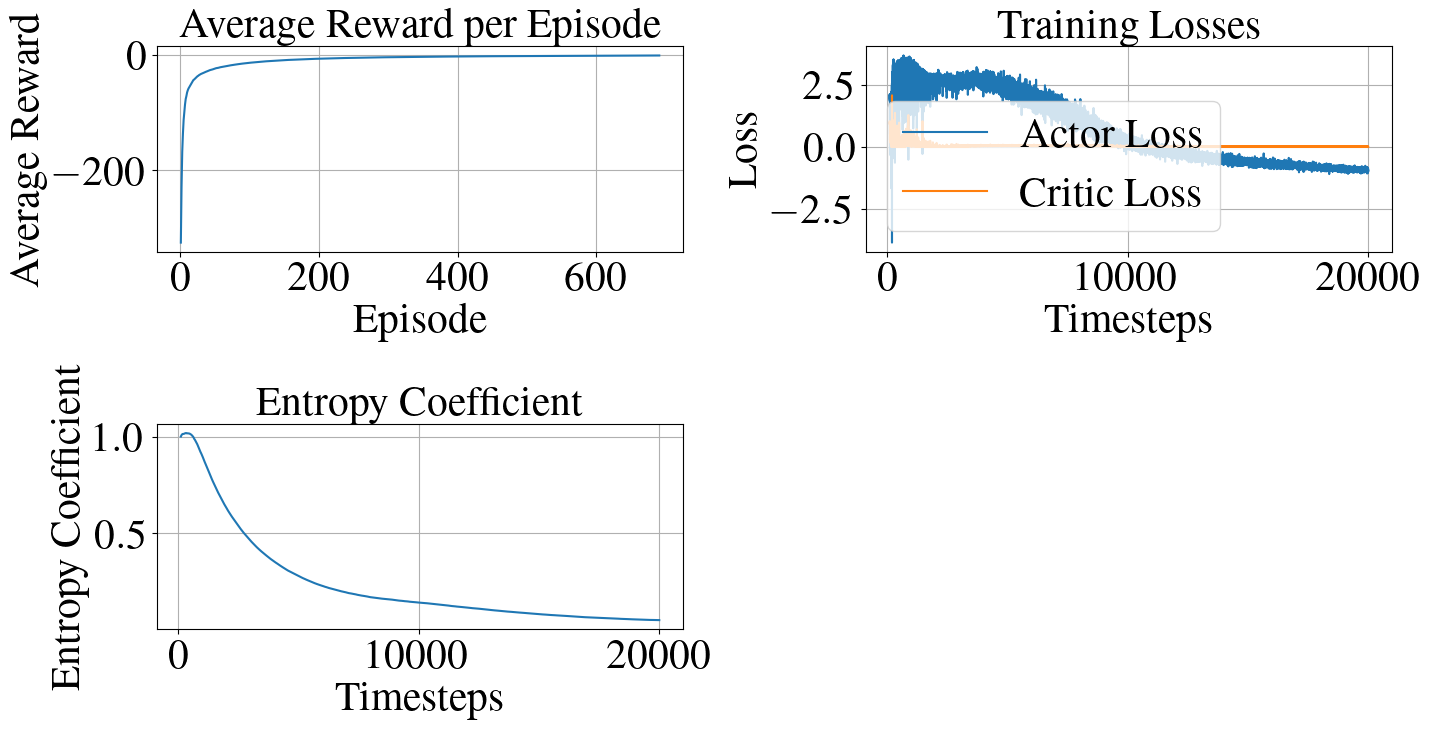

TQC training time: 470.86 seconds
------------------------------------------------------------
Training TD3 adaptive controller with alpha = 100.0
S1 is: -7.88820340382393e-18
S1 is: -7.88820340382393e-18
S1 is: -7.88820340382393e-18
S1 is: -7.88820340382393e-18
S1 is: -7.88820340382393e-18
S1 is: -7.88820340382393e-18


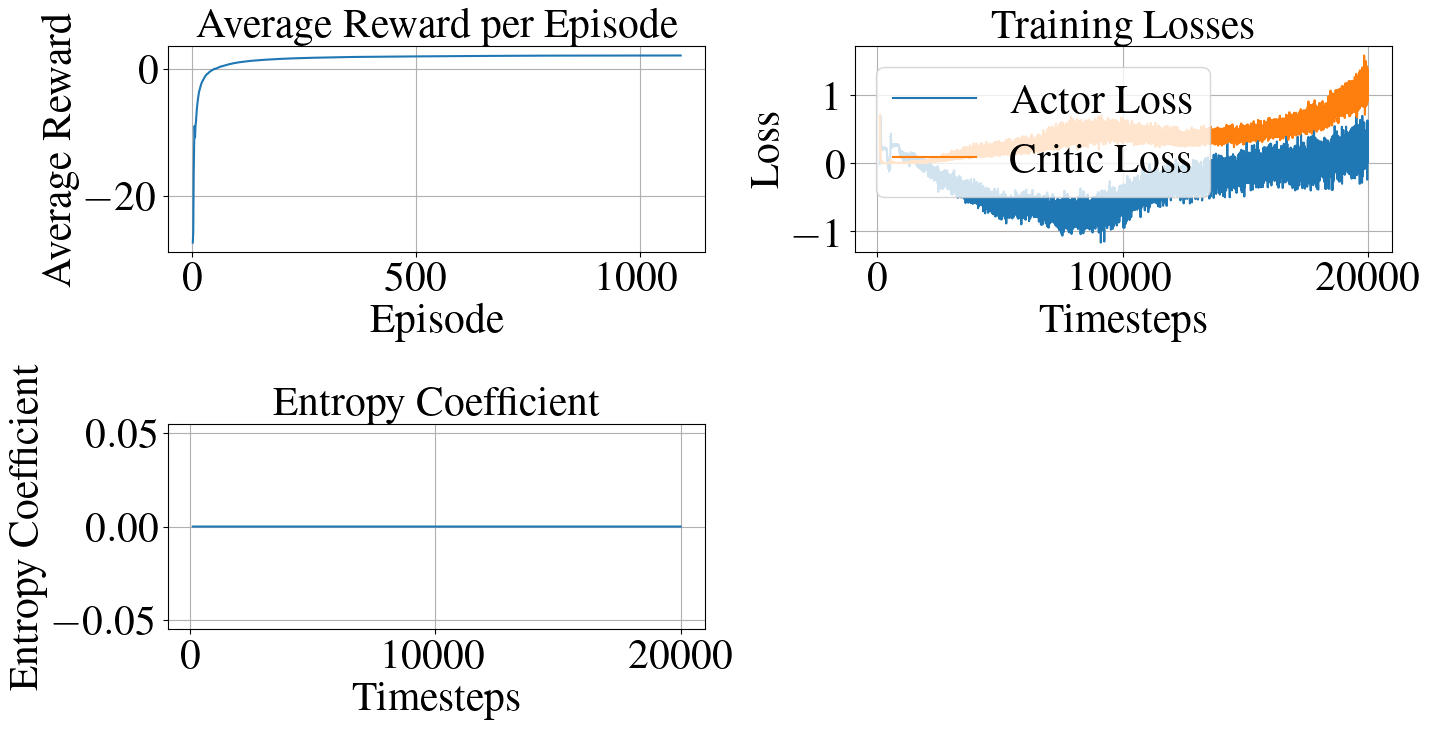

TD3 training time: 465.10 seconds
Preparing training runs with alpha = 1000.0
------------------------------------------------------------
Training TQC adaptive controller with alpha = 1000.0


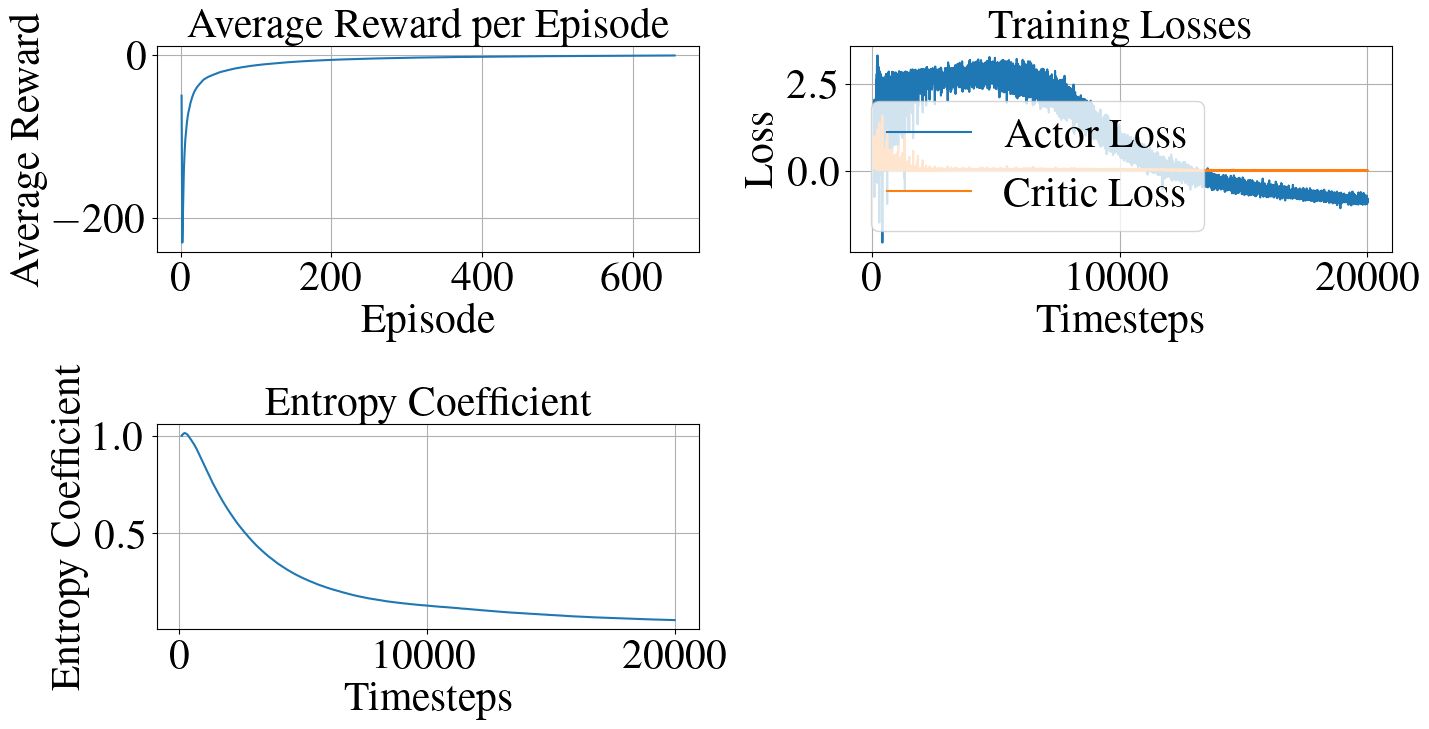

TQC training time: 457.88 seconds
------------------------------------------------------------
Training TD3 adaptive controller with alpha = 1000.0
S1 is: -3.353112494514363e-17
S1 is: -3.353112494514363e-17
S1 is: -3.353112494514363e-17
S1 is: -3.353112494514363e-17
S1 is: -3.353112494514363e-17
S1 is: -3.353112494514363e-17
S1 is: -3.353112494514363e-17
S1 is: -3.353112494514363e-17
S1 is: -3.353112494514363e-17
S1 is: -3.353112494514363e-17
S1 is: -3.353112494514363e-17
S1 is: -3.353112494514363e-17
S1 is: -3.353112494514363e-17
S1 is: -3.353112494514363e-17
S1 is: -3.353112494514363e-17
S1 is: -3.353112494514363e-17
S1 is: -3.353112494514363e-17
S1 is: -3.353112494514363e-17
S1 is: -3.353112494514363e-17
S1 is: -3.353112494514363e-17
S1 is: -3.353112494514363e-17
S1 is: -3.353112494514363e-17
S1 is: -3.353112494514363e-17
S1 is: -3.353112494514363e-17
S1 is: -3.353112494514363e-17
S1 is: -3.353112494514363e-17
S1 is: -3.353112494514363e-17
S1 is: -3.353112494514363e-17
S1 is: -3.35

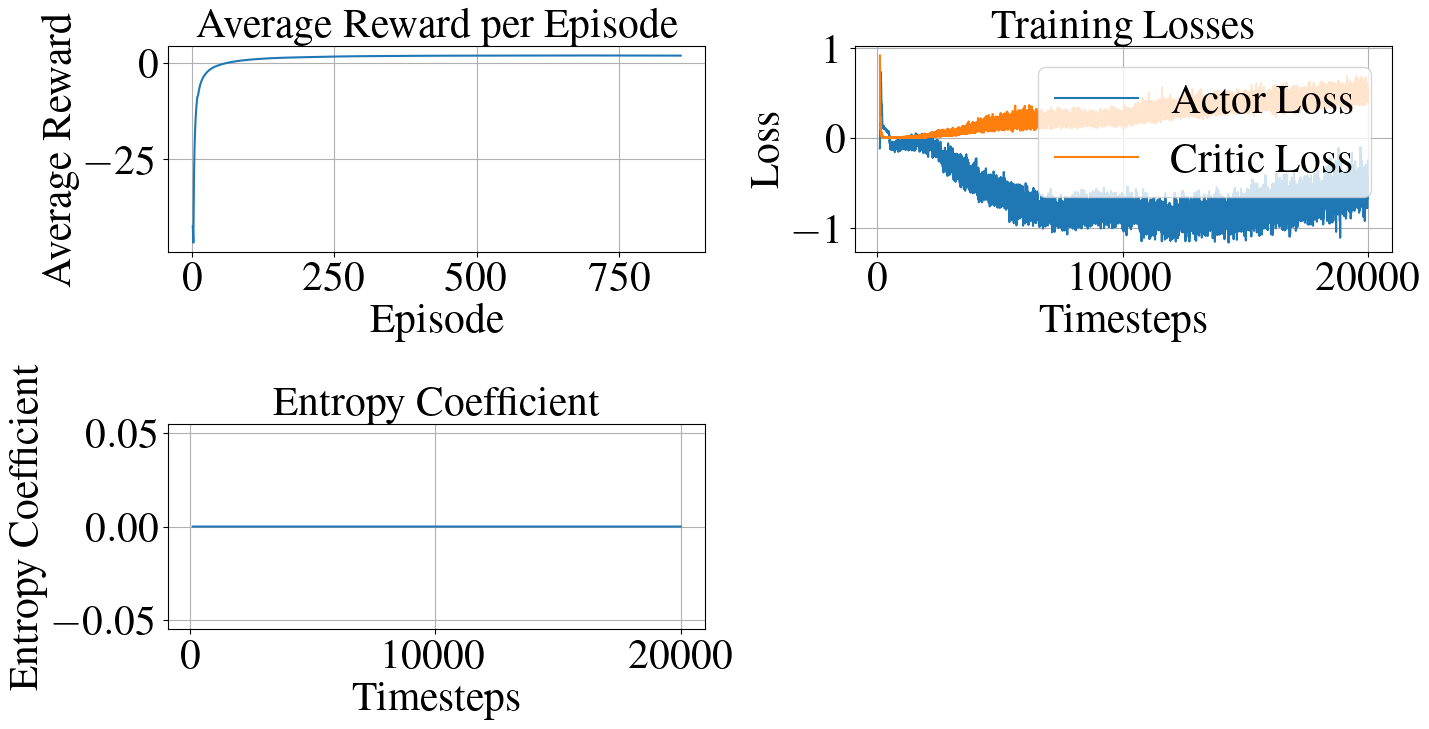

TD3 training time: 455.32 seconds
Completed alpha sweep training. Models stored in: rl_runs


In [26]:
from Solve_IVP_NS.projections import CoulombProjection
from Solve_IVP_NS.nonlinear_solvers import ImplicitEquationSolver
from Solve_IVP_NS.integrations import CompositeMethod
from Solve_IVP_NS.ODESystem import ODESystem
from Solve_IVP_NS.ODESolver import ODESolver
from Solve_IVP_NS.rl.callbacks import CustomMetricsCallback
from gymnasium import spaces
from pathlib import Path
import json
from copy import deepcopy



# Component slices (each DOF separately) and constraint indices (only DOF 0 is constrained)
# Component slice layout
component_slices = [
    slice(0, N_DOFS),
    slice(N_DOFS, 2 * N_DOFS),
    slice(2 * N_DOFS, 3 * N_DOFS)
 ]
# For constrained DOF 0 we set rhok=1.0; unconstrained DOF 1 gets 0.
rhok = np.array([1.0])

# Create the projection operator
projection = CoulombProjection(
    con_force_func=con_force,
    rhok=rhok,
    component_slices=component_slices,
    constraint_indices= list(range(N_DOFS)),
    use_numba=True  # use Numba acceleration
)

# Configure the implicit solver (using the VI method here)
solver_mp = ImplicitEquationSolver(
    method='VI',
    proj=projection,
    component_slices=component_slices,
    tol=1e-10,
    max_iter=100,
 )

# Use the composite method (which calls the solver internally)
method_mp = CompositeMethod(solver=solver_mp, A = A)

# --- Adaptive RL training over an alpha sweep ---
# Here we iterate over a list of alpha values, train a policy for each,
# and persist the resulting models, normalization stats, and metadata
# into per-alpha subdirectories for easy organization.
dt0 = 1e-3
t0 = t_span[0]
tnmax = t_span[1]
dt_min = 1e-3* fault.second / fault.Tscale
dt_max =30/4 * fault.second / fault.Tscale
nparams = (1e-6, 500)

# Define the observation space (here we use the 3 state variables plus 3 extra features regarding solver performance)
obs_dim = 6
obs_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float64)

alpha_grid = [ 0.01, 0.1, 1.0, 2.0, 10.0, 100.0, 1000.0]  # customize as desired
total_timesteps = 20_000
RUN_ROOT = Path("rl_runs")
RUN_ROOT.mkdir(parents=True, exist_ok=True)

def _alpha_label(alpha_value: float) -> str:
    sign = "m" if alpha_value < 0 else ""
    magnitude = str(abs(alpha_value)).replace(".", "p")
    return f"{sign}{magnitude}"

_base_policy_kwargs = dict(
    activation_fn=th.nn.ReLU,
    net_arch=dict(pi=[64, 64], qf=[64, 64, 64])
)

def _policy_kwargs():
    return dict(_base_policy_kwargs)

def _build_tqc(vec_env):
    return TQC(
        "MlpPolicy",
        vec_env,
        batch_size=256,
        use_sde=True,
        verbose=0,
        policy_kwargs=_policy_kwargs()
)

def _build_td3(vec_env):
    return TD3(
        "MlpPolicy",
        vec_env,
        batch_size=256,
        verbose=0,
        policy_kwargs=_policy_kwargs()
)

algorithms = {
    "TQC": dict(builder=_build_tqc),
    "TD3": dict(builder=_build_td3),
}

for alpha_value in alpha_grid:
    print("=" * 60)
    print(f"Preparing training runs with alpha = {alpha_value}")
    alpha_dir = RUN_ROOT / f"alpha_{_alpha_label(alpha_value)}"
    alpha_dir.mkdir(parents=True, exist_ok=True)

    reward_fn = build_reward_fn(alpha_value)
    obs_fn = build_obs_fn(alpha_value)

    def make_env():
        return AdaptiveStepperEnv(
            system=rhs,
            dt0=dt0,
            t0=t0,
            x0=y0,
            tnmax=tnmax,
            dt_min=dt_min,
            dt_max=dt_max,
            nparams=nparams,
            integrator=method_mp,
            component_slices=component_slices,
            reward_fn=reward_fn,
            obs_fn=obs_fn,
            obs_space=obs_space,
            verbose=False,
            # atol=1e-8,
            # rtol=1e-6,
            alpha=alpha_value,  # ensure env.alpha matches this run's alpha
)

    for algo_name, algo_cfg in algorithms.items():
        print("-" * 60)
        print(f"Training {algo_name} adaptive controller with alpha = {alpha_value}")
        vec_env = DummyVecEnv([make_env])
        vec_env = VecNormalize(vec_env, norm_obs=False, norm_reward=False)
        model = algo_cfg["builder"](vec_env)

        metrics_callback = CustomMetricsCallback()
        start_time = time.time()
        model.learn(total_timesteps=total_timesteps, callback=[metrics_callback])
        elapsed = time.time() - start_time
        print(f"{algo_name} training time: {elapsed:.2f} seconds")

        run_dir = alpha_dir / algo_name
        run_dir.mkdir(parents=True, exist_ok=True)
        model_path = run_dir / "model"
        vecnorm_path = run_dir / "vec_norm.pkl"
        meta_path = run_dir / "metadata.json"
        model.save(str(model_path))
        vec_env.save(str(vecnorm_path))

        meta = {
            "alpha": alpha_value,
            "algorithm": algo_name,
            "total_timesteps": total_timesteps,
            "training_wall_time_sec": elapsed,
            "model_path": str(model_path.with_suffix('.zip')),
            "vecnorm_path": str(vecnorm_path),
        }
        with open(meta_path, "w", encoding="utf-8") as fh:
            json.dump(meta, fh, indent=2)

        vec_env.close()
        del vec_env, model

print("Completed alpha sweep training. Models stored in:", RUN_ROOT)

## Evaluation: roll out each trained alpha and compare to adaptive integrator

This section loads each trained RL policy from `rl_runs/alpha_*`, runs a rollout on the same fault setup, and plots:
- Average velocity over DOFs vs. time
- Average slip over DOFs vs. time
It also adds the adaptive integrator baseline computed earlier and builds a small runtime table.

Notes:
- No training happens here; we only load saved artifacts.
- We assume models were saved by the training cell into `rl_runs/alpha_<label>/model(.zip)` with optional `vec_norm.pkl`.
- Observation normalization is the same as training (your `my_obs_fn`) and uses per-discretization scalars already defined above.

Evaluating TD3 alpha=0.01 from alpha_0p01/TD3...
Finished TD3 alpha=0.01: wall=0.363s, steps=20, t_end=34.85154520225636
Evaluating TQC alpha=0.01 from alpha_0p01/TQC...
Finished TD3 alpha=0.01: wall=0.363s, steps=20, t_end=34.85154520225636
Evaluating TQC alpha=0.01 from alpha_0p01/TQC...
Finished TQC alpha=0.01: wall=0.340s, steps=18, t_end=35.92141483062271
Evaluating TD3 alpha=0.1 from alpha_0p1/TD3...
Finished TQC alpha=0.01: wall=0.340s, steps=18, t_end=35.92141483062271
Evaluating TD3 alpha=0.1 from alpha_0p1/TD3...
Finished TD3 alpha=0.1: wall=0.309s, steps=17, t_end=35.8566100920134
Evaluating TQC alpha=0.1 from alpha_0p1/TQC...
Finished TD3 alpha=0.1: wall=0.309s, steps=17, t_end=35.8566100920134
Evaluating TQC alpha=0.1 from alpha_0p1/TQC...
Finished TQC alpha=0.1: wall=0.381s, steps=19, t_end=35.286434307148866
Evaluating TD3 alpha=1000 from alpha_1000p0/TD3...
Finished TQC alpha=0.1: wall=0.381s, steps=19, t_end=35.286434307148866
Evaluating TD3 alpha=1000 from alpha_1000p

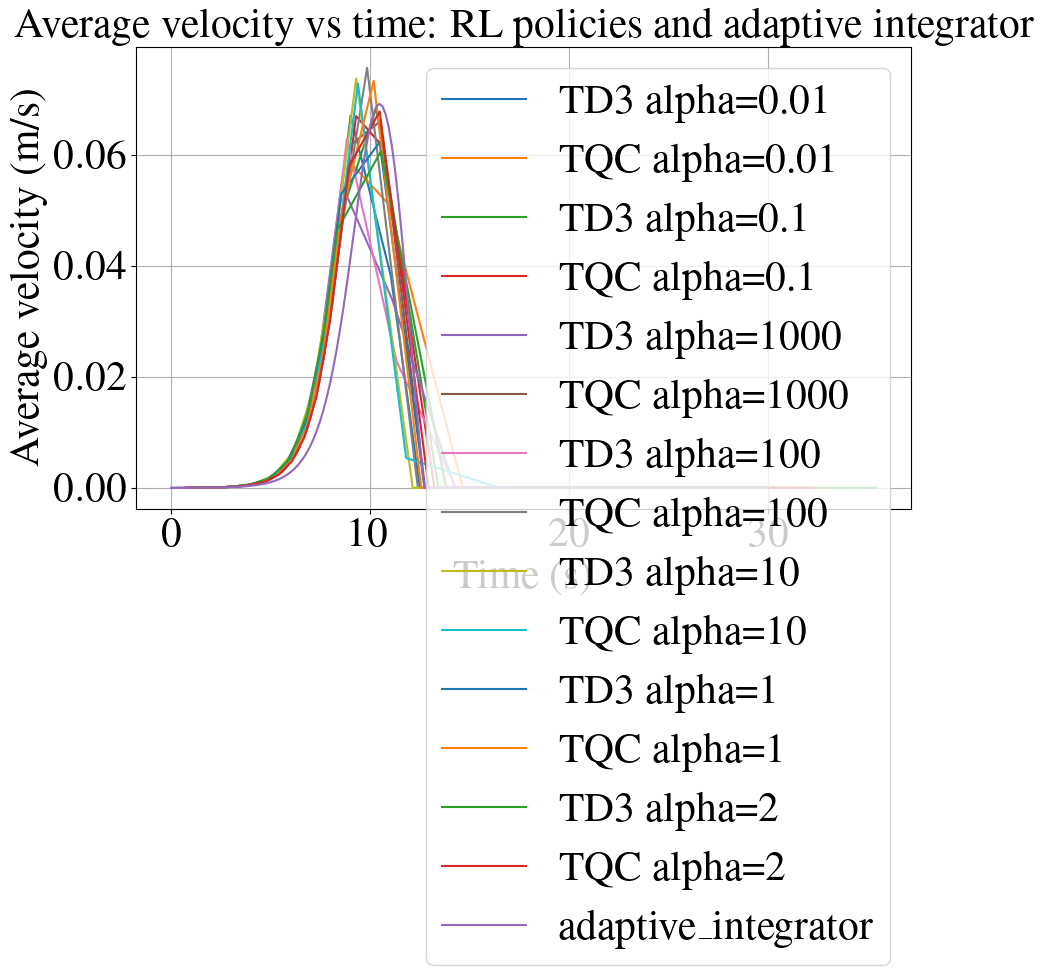

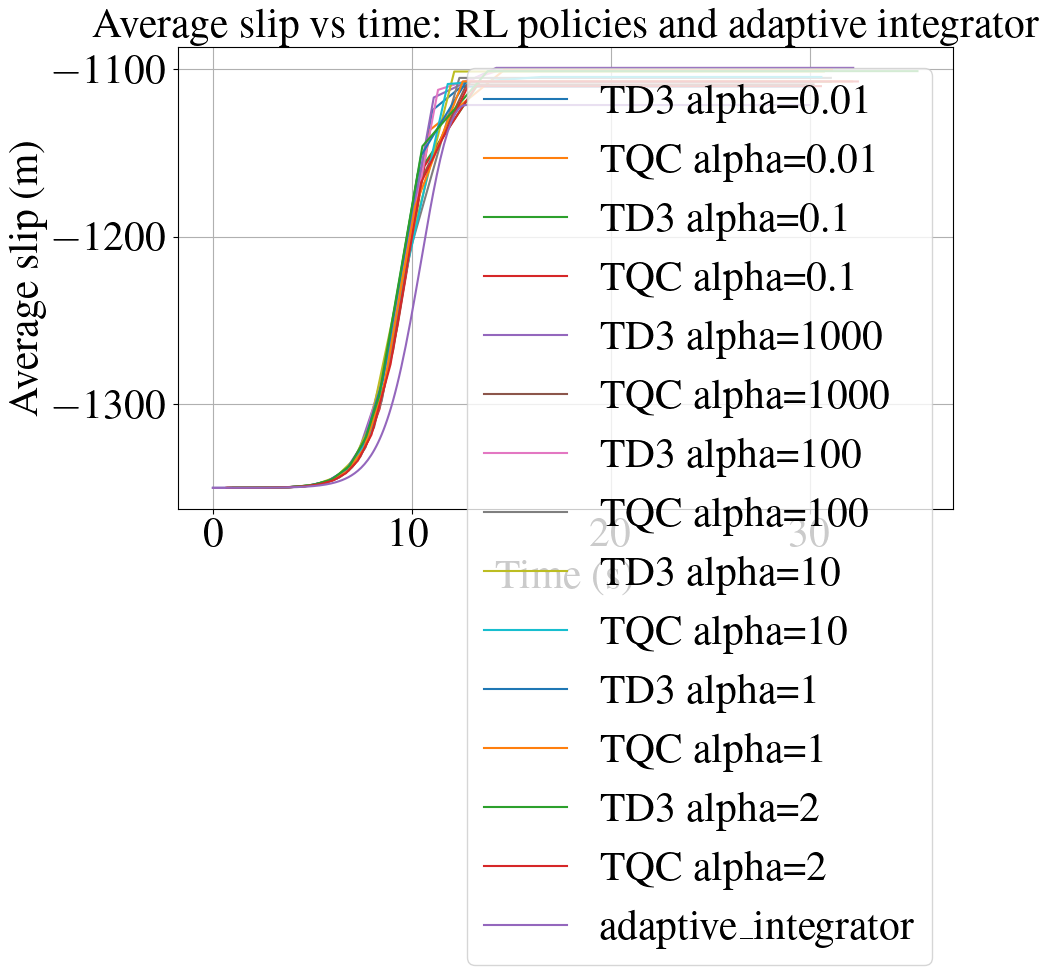

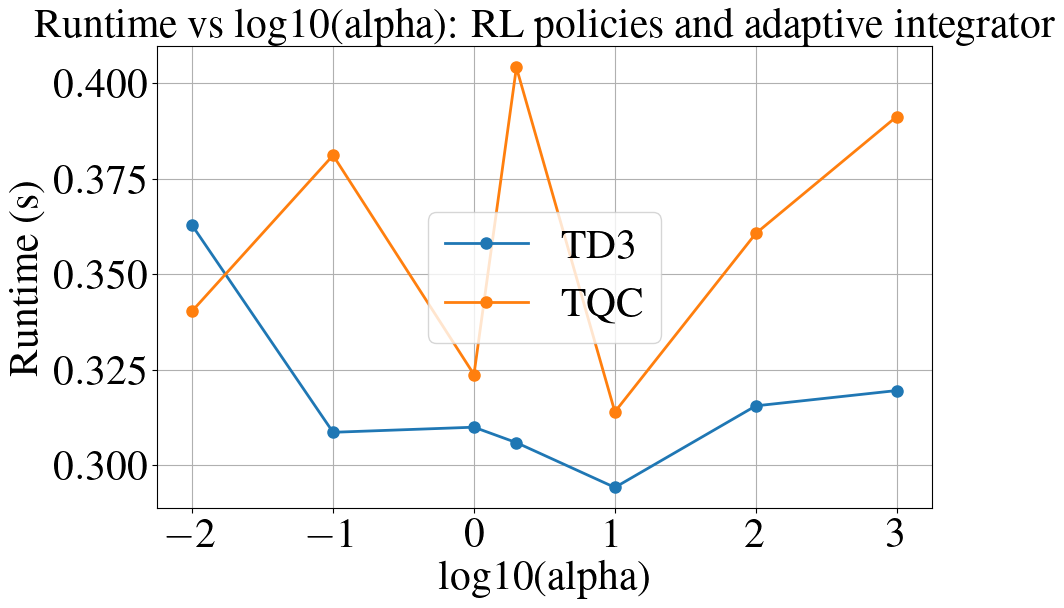

Runtime summary (seconds):


,method,wall_time_s
0,TD3 alpha=10,0.294158
1,TD3 alpha=2,0.305895
2,TD3 alpha=0.1,0.308598
3,TD3 alpha=1,0.309934
4,TQC alpha=10,0.313949
5,TD3 alpha=100,0.315518
6,TD3 alpha=1000,0.319528
7,TQC alpha=1,0.323719
8,TQC alpha=0.01,0.340343
9,TQC alpha=100,0.360648


In [35]:
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt
from sb3_contrib import TQC
from stable_baselines3 import TD3
import time
try:
    import pandas as pd
    from IPython.display import display
    _HAVE_PANDAS = True
except Exception:
    _HAVE_PANDAS = False

# Utility: format alpha subfolder names identical to training
def _alpha_label(alpha_value: float) -> str:
    sign = "m" if alpha_value < 0 else ""
    magnitude = str(abs(alpha_value)).replace(".", "p")
    return f"{sign}{magnitude}"

RUN_ROOT = Path("rl_runs").resolve()

ALGO_REGISTRY = {
    "TQC": TQC,
    "TD3": TD3,
}

# Discover trained runs from disk (alpha_* folders)
alpha_dirs = sorted([p for p in RUN_ROOT.glob("alpha_*") if p.is_dir()])
if not alpha_dirs:
    raise FileNotFoundError(f"No trained runs found under {RUN_ROOT}. Expected folders like alpha_1p0/TQC, alpha_10p0/TD3, ...")

# Helper to rebuild the same environment used for training
def make_eval_env(reward_fn, obs_fn, alpha_value: float):
    return AdaptiveStepperEnv(
        system=rhs,
        dt0=dt0,
        t0=t0,
        x0=y0,
        tnmax=tnmax,
        dt_min=dt_min,
        dt_max=dt_max,
        nparams=nparams,
        integrator=method_mp,
        component_slices=component_slices,
        reward_fn=reward_fn,  # not used in deterministic rollout, but env expects it
        obs_fn=obs_fn,
        obs_space=obs_space,
        verbose=False,
        # atol=1e-8,
        # rtol=1e-6,
        alpha=alpha_value,   # ensure env.alpha is set (for completeness)
)

def rollout_policy_on_env(model, env, run_name="(unnamed)"):
    obs, info = env.reset()
    times = []
    mean_vel = []
    mean_slip = []
    start = time.time()
    done = False
    term = False
    # Repeated-time guard
    last_t = None
    repeat_count = 0
    while not (done or term):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, term, info = env.step(action)
        t_now = info.get("t_k1", np.nan)
        # Check for repeated time values to avoid infinite loops
        current_t = None if t_now is None or np.isnan(t_now) else float(t_now)
        if current_t is not None:
            if last_t is not None and np.isclose(current_t, last_t, rtol=0.0, atol=1e-12):
                repeat_count += 1
                if repeat_count >= 10:
                    print(f"[{run_name}] WARNING: Time stuck at {current_t} for 10 iterations, breaking loop")
                    break
            else:
                repeat_count = 0  # Reset counter if time advances
            last_t = current_t
        xk = info.get("xk", None)
        if xk is not None:
            n = N_DOFS
            v = xk[:n]
            u = xk[n:2*n]
            times.append(float(t_now))
            mean_vel.append(float(np.mean(v)))
            # print(np.mean(v))
            mean_slip.append(float(np.mean(u)))
    wall = time.time() - start
    # Convert to arrays
    return np.asarray(times), np.asarray(mean_vel), np.asarray(mean_slip), wall

# Storage for plotting and table
series = {}  # key -> dict(times, mean_v, mean_u, runtime)

for alpha_dir in alpha_dirs:
    algo_dirs = sorted([p for p in alpha_dir.iterdir() if p.is_dir()])
    if not algo_dirs:
        print(f"Skipping {alpha_dir.name}: no algorithm runs found")
        continue
    for algo_dir in algo_dirs:
        algo_name = algo_dir.name
        ModelClass = ALGO_REGISTRY.get(algo_name)
        if ModelClass is None:
            print(f"Skipping {algo_dir}: unknown algorithm '{algo_name}'")
            continue
        meta_path = algo_dir / "metadata.json"
        model_path_zip = algo_dir / "model.zip"
        model_path_plain = algo_dir / "model"

        if not meta_path.exists():
            print(f"Skipping {algo_dir}: missing metadata.json")
            continue
        with open(meta_path, "r", encoding="utf-8") as fh:
            meta = json.load(fh)
        alpha_value = float(meta.get("alpha", np.nan))
        if np.isnan(alpha_value):
            # Try to parse from parent folder name: alpha_1p0 -> 1.0
            try:
                alabel = alpha_dir.name.split("alpha_")[-1]
                alpha_value = float(alabel.replace("p", ".").replace("m", "-"))
            except Exception:
                print(f"Could not infer alpha from {alpha_dir.name}; skipping {algo_dir}")
                continue

        key = f"{algo_name} alpha={alpha_value:g}"
        print(f"Evaluating {key} from {(algo_dir.relative_to(RUN_ROOT))}...")

        # Build reward/obs EXACTLY as training for this alpha
        reward_fn = build_reward_fn(alpha_value)
        obs_fn = build_obs_fn(alpha_value)
        env = make_eval_env(reward_fn, obs_fn, alpha_value)

        mdl_path = str(model_path_zip) if model_path_zip.exists() else str(model_path_plain)
        if not Path(mdl_path).exists():
            print(f"Skipping {algo_dir}: no model found at {model_path_zip} or {model_path_plain}")
            continue
        model = ModelClass.load(mdl_path, device="cpu")

        # Rollout
        try:
            t_arr, v_mean, u_mean, wall = rollout_policy_on_env(model, env, run_name=key)
            print(f"Finished {key}: wall={wall:.3f}s, steps={len(t_arr)}, t_end={(t_arr[-1] if len(t_arr)>0 else 'NA')}")
            series[key] = {
                "times": t_arr,
                "mean_v": v_mean,
                "mean_u": u_mean,
                "runtime_s": wall,
            }
        except Exception as e:
            print(f"FAILED {key}: {e}")
            continue

# Baseline: adaptive integrator (from earlier SSN run or re-run if needed)
def adaptive_integrator_baseline():
    # Use Solve_IVP_NS.solve_ivp_ns as in the earlier cell
    try:
        t_vals_b = t_vals_ssn
        y_vals_b = y_vals_ssn
        wall_b = rt_nb
    except NameError:
        start_b = time.time()
        projection_opts_nb = dict(projection_opts)
        projection_opts_nb['use_numba'] = True
        (t_vals_b, y_vals_b, h_vals_b, fk_vals_b, solver_info_b) = Solve_IVP_NS.solve_ivp_ns(
            fun=rhs,
            t_span=t_span,
            y0=y0,
            method='composite',
            projection='coulomb',
            solver='VI',
            projection_opts=projection_opts_nb,
            solver_opts=solver_opts_ssn,
            adaptive=True,
            adaptive_opts=adaptive_opts,
            atol=1e-6,
            rtol=1e-3,
            h0=adaptive_opts['h0'],
            component_slices=component_slices,
            verbose=False,
            A=A,
        )
        wall_b = time.time() - start_b
    n = N_DOFS
    v_b = np.mean(y_vals_b[:, :n], axis=1)
    u_b = np.mean(y_vals_b[:, n:2*n], axis=1)
    return t_vals_b, v_b, u_b, wall_b

t_b, v_b, u_b, wall_b = adaptive_integrator_baseline()
series["adaptive_integrator"] = {
    "times": np.asarray(t_b),
    "mean_v": np.asarray(v_b),
    "mean_u": np.asarray(u_b),
    "runtime_s": float(wall_b),
}

# Plot velocity
plt.figure(figsize=(10,6))
for name, data in series.items():
    t_plot = data["times"] * fault.Tscale / fault.second
    v_plot = data["mean_v"] * fault.Vscale
    plt.plot(t_plot, v_plot, label=name)
plt.xlabel("Time (s)")
plt.ylabel("Average velocity (m/s)")
plt.title("Average velocity vs time: RL policies and adaptive integrator")
plt.grid(True)
plt.legend()
plt.show()

# Plot slip
plt.figure(figsize=(10,6))
for name, data in series.items():
    t_plot = data["times"] * fault.Tscale / fault.second
    u_plot = data["mean_u"] * fault.Dscale
    plt.plot(t_plot, u_plot, label=name)
plt.xlabel("Time (s)")
plt.ylabel("Average slip (m)")
plt.title("Average slip vs time: RL policies and adaptive integrator")
plt.grid(True)
plt.legend()
plt.show()

# Plot runtime vs log10(alpha)
from collections import defaultdict
runtime_by_algo = defaultdict(list)
baseline_runtime = None

for name, data in series.items():
    # Extract alpha from the key name (e.g., "TQC alpha=1.0")
    if "alpha=" in name:
        parts = name.split("alpha=")
        algo = parts[0].strip()
        alpha = float(parts[1])
        runtime = data["runtime_s"]
        runtime_by_algo[algo].append((alpha, runtime))
    elif "adaptive_integrator" in name:
        baseline_runtime = data["runtime_s"]

if runtime_by_algo:
    plt.figure(figsize=(10, 6))
    for algo_name, pairs in runtime_by_algo.items():
        pairs_sorted = sorted(pairs, key=lambda x: x[0])
        alphas = [p[0] for p in pairs_sorted]
        runtimes = [p[1] for p in pairs_sorted]
        plt.plot(np.log10(alphas), runtimes, marker='o', label=algo_name, linewidth=2, markersize=8)
    
    # if baseline_runtime is not None:
    #     plt.axhline(baseline_runtime, color='k', linestyle='--', linewidth=2, label='adaptive integrator baseline')
    
    plt.xlabel("log10(alpha)")
    plt.ylabel("Runtime (s)")
    plt.title("Runtime vs log10(alpha): RL policies and adaptive integrator")
    plt.grid(True)
    plt.legend()
    plt.show()

# Runtime table
rows = [{"method": name, "wall_time_s": data["runtime_s"]} for name, data in series.items()]
if _HAVE_PANDAS:
    df = pd.DataFrame(rows).sort_values("wall_time_s").reset_index(drop=True)
    print("Runtime summary (seconds):")
    display(df)
else:
    print("Runtime summary (seconds):")
    for row in sorted(rows, key=lambda r: r["wall_time_s"]):
        print(f"- {row['method']}: {row['wall_time_s']:.3f}s")